# DMW2 Lab 1

In [ ]:
import os
import gzip
import json
import isbnlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For scaling data
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN, AgglomerativeClustering  # DBSCAN & Hierarchical Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
data_base_path = "../data/"

In [3]:
def read_txt(file_path, total_lines, valid_cols):
    """
    Reads a tab-separated text file and extracts JSON data from the fifth column, 
    filtering it based on valid column keys.

    Parameters
    ----------
    file_path : str
        Path to the input text file.
    total_lines : int
        Estimated total number of lines in the file (used for tqdm progress bar).
    valid_cols : list of str
        List of valid keys to extract from the JSON data.

    Returns
    -------
    dict
        A dictionary where each key is a line index and the value is a dictionary 
        containing the extracted JSON fields that match `valid_cols`.
    """
    df_dict = {}
    
    with open(file_path, "r", encoding="utf-8") as infile:
        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing lines")):
            # if idx > 10000:
            #     break
            parts = line.strip().split("\t")
            
            if len(parts) < 5:
                continue 

            try:
                json_data = json.loads(parts[4])
                
                for key in json_data.keys():
                    df_dict[idx] = {key: json_data.get(key, np.nan) for key in valid_cols if key in json_data}
                
            except json.JSONDecodeError:
                continue

    return df_dict

## Data Cleaning

In [4]:
# !zgrep -E '"publish_date": "(20(1[6-9]|[2-9][0-9]))([^"]*)?"' /mnt/data/public/openlibrary/20221007/ol_dump_editions_latest.txt.gz > editions_after_2015.txt

In [5]:
extracted_files = {
    "editions": {
        "file_path": os.path.join(data_base_path, "editions_after_2015.txt"),
        "total_lines": 4259552,
    },
    "works": {
        "file_path": os.path.join(data_base_path, "filtered_works_with_editions.txt"),
        "total_lines": 909883,
    },
    "authors": {
        "file_path": os.path.join(data_base_path, "filtered_authors_with_works_and_editions.txt"),
        "total_lines": 853086,
    }
}

In [6]:
record_type = "editions"

ed_cols = [
    "key", "works", "title", "publishers", "description", "first_sentence", "subjects", "languages",
    "publish_date", "publish_country", "number_of_pages", "latest_revision", "revision"
]

file_path, total_lines = extracted_files[record_type]["file_path"], extracted_files[record_type]["total_lines"]
editions_dict = read_txt(file_path, total_lines, ed_cols)

Processing lines: 100%|██████████| 4259552/4259552 [03:55<00:00, 18058.12it/s]


In [7]:
editions_df = pd.DataFrame.from_dict(editions_dict, orient="index")
editions_df.head()

,key,works,title,publishers,description,publish_date,number_of_pages,latest_revision,revision,languages,subjects,publish_country,first_sentence
0,/books/OL24367788M,[{'key': '/works/OL15386091W'}],Akademia Canterwood: Wysokie Aspiracje,[PUBLICAT S. A.],"{'type': '/type/text', 'value': 'W elitarnym g...",2016,213.0,5.0,5,NaN,NaN,NaN,NaN
1,/books/OL25896697M,[{'key': '/works/OL17321171W'}],Too Blessed to Be Stressed,[Barbour],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN
2,/books/OL25896725M,[{'key': '/works/OL17321197W'}],"Fuera llueve, dentro también, ¿paso a buscarte?",[Montena],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
3,/books/OL25898027M,[{'key': '/works/OL17322236W'}],Satin Island,[Pálido Fuego],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
4,/books/OL25898429M,[{'key': '/works/OL17322587W'}],La península de Cilemaga,[Pregunta Ediciones],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN


In [8]:
del editions_dict

In [9]:
editions_df.shape

(4259552, 13)

In [10]:
editions_df.isna().sum() / len(editions_df) * 100

key                 0.000000
works               0.000610
title               0.000916
publishers          1.484264
description        98.352033
publish_date        0.000000
number_of_pages    70.451071
latest_revision     0.000047
revision            0.000000
languages           1.504712
subjects           69.716768
publish_country    97.697199
first_sentence     99.977556
dtype: float64

In [11]:
final_cols = ["key", "works", "title", "publishers", "publish_date", "languages", "subjects"]

drp_df = editions_df[final_cols]
del editions_df

In [12]:
drp_df

,key,works,title,publishers,publish_date,languages,subjects
0,/books/OL24367788M,[{'key': '/works/OL15386091W'}],Akademia Canterwood: Wysokie Aspiracje,[PUBLICAT S. A.],2016,NaN,NaN
1,/books/OL25896697M,[{'key': '/works/OL17321171W'}],Too Blessed to Be Stressed,[Barbour],2016,NaN,NaN
2,/books/OL25896725M,[{'key': '/works/OL17321197W'}],"Fuera llueve, dentro también, ¿paso a buscarte?",[Montena],2016,NaN,NaN
3,/books/OL25898027M,[{'key': '/works/OL17322236W'}],Satin Island,[Pálido Fuego],2016,NaN,NaN
4,/books/OL25898429M,[{'key': '/works/OL17322587W'}],La península de Cilemaga,[Pregunta Ediciones],2016,NaN,NaN
...,...,...,...,...,...,...,...
4259547,/books/OL39793833M,[{'key': '/works/OL28940769W'}],Chile Project,[Princeton University Press],2023,[{'key': '/languages/eng'}],NaN
4259548,/books/OL39793914M,[{'key': '/works/OL28909366W'}],Is for Alexander,[History Unboxed],2022,[{'key': '/languages/eng'}],"[Biography, World history]"
4259549,/books/OL39794994M,[{'key': '/works/OL28941712W'}],Les limaces,[Éditions Michel Quintin],2016,[{'key': '/languages/fre'}],"[Slugs (Mollusks), Juvenile literature, Limace..."
4259550,/books/OL39796695M,[{'key': '/works/OL13360036W'}],Guía geológica del Pirineo,[Pirineo],2022,NaN,NaN


keep cols with less than 70% missing values

In [13]:
drp_df["publishers"] = drp_df["publishers"].str[0]
drp_df["publishers"].fillna("Self-published", inplace=True)
drp_df["publish_year"] = ([int(x[:4]) for x in drp_df["publish_date"]])
drp_df["subjects"] = drp_df["subjects"].str.join(", ")
drp_df["works"] = drp_df["works"].apply(lambda x: x[0]["key"] if isinstance(x, list) and x else None)
drp_df["languages"] = drp_df["languages"].apply(
    lambda x: x[0]["key"].split("/")[-1] if isinstance(x, list) and x and "key" in x[0] else np.nan
)

final_editions_df = drp_df.dropna(subset=["title", "languages", "subjects"])

del drp_df

In [14]:
final_editions_df

,key,works,title,publishers,publish_date,languages,subjects,publish_year
67,/books/OL26450333M,/works/OL17868105W,West of Eden,Self-published,2016,eng,"Social life and customs, PERFORMING ARTS, Hist...",2016
72,/books/OL26453406M,/works/OL17872089W,What you always wanted,Self-published,2016,eng,"JUVENILE FICTION / Social Themes / Friendship,...",2016
82,/books/OL26474165M,/works/OL17897021W,The Kentucky cowboy's baby,Harlequin Books,2016,eng,"Fiction, Ranches, Man-woman relationships, Phy...",2016
87,/books/OL26487791M,/works/OL17912752W,Breakthrough,Self-published,2016,eng,"Women presidents, Women politicians, Kvinnliga...",2016
112,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,2016,chi,"Zhang pian xiao shuo, Er tong wen xue",2016
...,...,...,...,...,...,...,...,...
4259502,/books/OL39784786M,/works/OL28903893W,Abby's Pony Love,Hastings Creations Group,2022,eng,"Children's fiction, Pets",2022
4259516,/books/OL39786866M,/works/OL28852046W,Fea,KV Books LLC,2022,eng,"Fiction, lgbtq+, gay, Fiction, general",2022
4259540,/books/OL39791850M,/works/OL28939362W,Sketch Tour of Yale University,Joseph Merritt Company,2022,eng,"Architecture, Art",2022
4259548,/books/OL39793914M,/works/OL28909366W,Is for Alexander,History Unboxed,2022,eng,"Biography, World history",2022


In [15]:
final_editions_df.dtypes

key             object
works           object
title           object
publishers      object
publish_date    object
languages       object
subjects        object
publish_year     int64
dtype: object

In [16]:
final_editions_df.languages.value_counts()

languages
eng    1238882
ger      11544
spa      10917
chi       8785
fre       4815
        ...   
nyn          1
nic          1
lin          1
gmh          1
tet          1
Name: count, Length: 152, dtype: int64

In [ ]:
final_editions_df["text"] = final_editions_df[["title", "subjects"]].astype(str).agg(" ".join, axis=1)

## EDA

In [ ]:
east_asian_editions_df = final_editions_df[final_editions_df["languages"].isin(["jpn", "kor", "chi"])].drop("publish_date", axis=1)
east_asian_editions_df

In [ ]:
east_asian_editions_df[east_asian_editions_df["languages"]=="jpn"]

In [ ]:
east_asian_editions_df[east_asian_editions_df["languages"]=="kor"]

In [ ]:
east_asian_editions_df[east_asian_editions_df["key"]=="/books/OL37824312M"]

In [ ]:
east_asian_editions_df.shape

In [ ]:
east_asian_editions_df.groupby("languages")["key"].nunique()

In [ ]:
east_asian_editions_df.reset_index(inplace=True)
east_asian_editions_df.drop("index", axis=1, inplace=True)

east_asian_editions_df

In [ ]:
japanese_stopwords = {"no", "wa", "wo", "ga", "to", "de", "kekkon"}  # Add more as needed
korean_stopwords = {"ŭl", "rŭl", "nŭn", "i", "ga", "e", "eseo", "yuga"}
chinese_stopwords = {"de", "shi", "zai", "you", "ta", "cheng", "xu"}

# Stopword removal function
def remove_stopwords(text, lang):
    words = text.lower().split()  # Convert to lowercase for consistency
    if lang == "chi":
        words = [word for word in words if word not in chinese_stopwords]
    elif lang == "jpn":
        words = [word for word in words if word not in japanese_stopwords]
    elif lang == "kor":
        words = [word for word in words if word not in korean_stopwords]
    return " ".join(words)

east_asian_editions_df["cleaned_subjects"] = east_asian_editions_df.apply(lambda row: remove_stopwords(row["subjects"], row["languages"]), axis=1)


In [76]:
east_asian_editions_df

,key,works,title,publishers,languages,subjects,publish_year,text,cleaned_subjects
0,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,chi,"Zhang pian xiao shuo, Er tong wen xue",2016,Bai ma ke xin de xing kong Zhang pian xiao shu...,"zhang pian xiao shuo, er tong wen xue"
1,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,chi,"Television mini-series, Chinese Television plays",2017,Bu dong sa jiao de nü ren Television mini-seri...,"television mini-series, chinese television plays"
2,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,chi,"Chinese essays, Anecdotes",2017,"Ren sheng a, zhen de shi mei xiang dao Chinese...","chinese essays, anecdotes"
3,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,chi,"Slow Electric cooking, Casserole cooking, Inte...",2017,Bruno Grill Pot duo gong neng wen zhu guo you ...,"slow electric cooking, casserole cooking, inte..."
4,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,chi,"Alternative treatment, Recipes, Constipation, ...",2016,"Chang bian Alternative treatment, Recipes, Con...","alternative treatment, recipes, constipation, ..."
...,...,...,...,...,...,...,...,...,...
11944,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,chi,"Labor laws and legislation, china, Labor contr...",2016,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Ji...,"labor laws and legislation, china, labor contr..."
11945,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,chi,"Yi dong zhong duan, Ying yong cheng xu, Cheng ...",2016,Android ying yong ce shi zhi nan Yi dong zhong...,"yi dong zhong duan, ying yong xu, she ji"
11946,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,chi,"Gao deng shu xue, Sheng xue can kao zi liao, S...",2016,GRE shu xue gao fen kuai su tu po Gao deng shu...,"gao deng shu xue, sheng xue can kao zi liao, s..."
11947,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,chi,Zhang pian xiao shuo,2016,Qing qiu hu chuan shuo Zhang pian xiao shuo,zhang pian xiao shuo


In [77]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
lang_encoded = encoder.fit_transform(east_asian_editions_df[["languages"]])
lang_df = pd.DataFrame(lang_encoded, columns=encoder.get_feature_names_out(["languages"]))
df_encoded = pd.concat([east_asian_editions_df, lang_df], axis=1).drop(columns=["languages"])

df_encoded

,key,works,title,publishers,subjects,publish_year,text,cleaned_subjects,languages_chi,languages_jpn,languages_kor
0,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,"Zhang pian xiao shuo, Er tong wen xue",2016,Bai ma ke xin de xing kong Zhang pian xiao shu...,"zhang pian xiao shuo, er tong wen xue",1.0,0.0,0.0
1,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,"Television mini-series, Chinese Television plays",2017,Bu dong sa jiao de nü ren Television mini-seri...,"television mini-series, chinese television plays",1.0,0.0,0.0
2,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,"Chinese essays, Anecdotes",2017,"Ren sheng a, zhen de shi mei xiang dao Chinese...","chinese essays, anecdotes",1.0,0.0,0.0
3,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,"Slow Electric cooking, Casserole cooking, Inte...",2017,Bruno Grill Pot duo gong neng wen zhu guo you ...,"slow electric cooking, casserole cooking, inte...",1.0,0.0,0.0
4,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,"Alternative treatment, Recipes, Constipation, ...",2016,"Chang bian Alternative treatment, Recipes, Con...","alternative treatment, recipes, constipation, ...",1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11944,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,"Labor laws and legislation, china, Labor contr...",2016,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Ji...,"labor laws and legislation, china, labor contr...",1.0,0.0,0.0
11945,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,"Yi dong zhong duan, Ying yong cheng xu, Cheng ...",2016,Android ying yong ce shi zhi nan Yi dong zhong...,"yi dong zhong duan, ying yong xu, she ji",1.0,0.0,0.0
11946,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,"Gao deng shu xue, Sheng xue can kao zi liao, S...",2016,GRE shu xue gao fen kuai su tu po Gao deng shu...,"gao deng shu xue, sheng xue can kao zi liao, s...",1.0,0.0,0.0
11947,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,Zhang pian xiao shuo,2016,Qing qiu hu chuan shuo Zhang pian xiao shuo,zhang pian xiao shuo,1.0,0.0,0.0


In [78]:
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust as needed

tfidf_matrix = vectorizer.fit_transform(df_encoded["cleaned_subjects"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

clustering_df = pd.concat([df_encoded.drop(columns=["subjects", "cleaned_subjects"]), tfidf_df], axis=1)

In [79]:
clustering_df

,key,works,title,publishers,publish_year,text,languages_chi,languages_jpn,languages_kor,04,...,écriture,écrivains,éducation,égard,émotions,état,étude,îles,ōme,ōsakajō
0,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,2016,Bai ma ke xin de xing kong Zhang pian xiao shu...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,2017,Bu dong sa jiao de nü ren Television mini-seri...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,2017,"Ren sheng a, zhen de shi mei xiang dao Chinese...",1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,2017,Bruno Grill Pot duo gong neng wen zhu guo you ...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,2016,"Chang bian Alternative treatment, Recipes, Con...",1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11944,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,2016,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Ji...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11945,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,2016,Android ying yong ce shi zhi nan Yi dong zhong...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11946,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,2016,GRE shu xue gao fen kuai su tu po Gao deng shu...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11947,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,2016,Qing qiu hu chuan shuo Zhang pian xiao shuo,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
svd = TruncatedSVD(n_components=min(tfidf_matrix.shape) - 1)
X_svd = svd.fit_transform(tfidf_matrix)

# Determine components for 90% variance
explained_variance = np.cumsum(svd.explained_variance_ratio_)
n_components = np.searchsorted(explained_variance, 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

Number of components to retain 90% variance: 1264


In [90]:
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(tfidf_matrix)

In [92]:
X_final = pd.DataFrame(X_svd, columns=[f"SV {i+1}" for i in range(X_svd.shape[1])])
X_final[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]] = df_encoded[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

## Clustering

In [96]:
X_scaled

array([[-0.65318691, -0.3138248 ,  5.20506178, ..., -0.24583864,
        -0.51215935,  0.60013279],
       [-0.2587703 , -0.44328693, -0.33047665, ..., -0.24583864,
        -0.51215935,  0.60013279],
       [ 0.30521615, -0.93583   , -0.30295964, ..., -0.24583864,
        -0.51215935,  0.60013279],
       ...,
       [-0.68402585, -0.17041122,  2.2607845 , ..., -0.24583864,
        -0.51215935,  0.60013279],
       [-0.64867237, -0.30983052,  4.90800744, ..., -0.24583864,
        -0.51215935,  0.60013279],
       [ 0.46470887, -0.16866605, -0.40490767, ..., -0.24583864,
        -0.51215935,  0.60013279]])

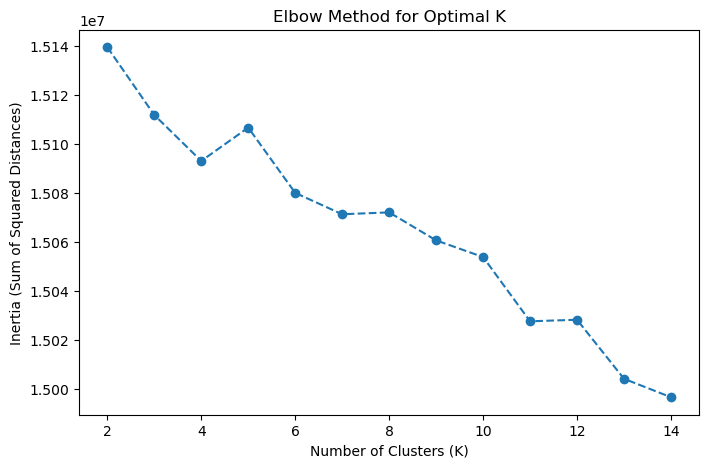

In [107]:
from sklearn.cluster import KMeans

inertia_values = []
k_range = range(2, 15)  # Testing clusters from 2 to 14

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [114]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# Print cluster counts
df_encoded["kmeans_cluster"].value_counts()

kmeans_cluster
1    8769
0    2416
3     753
2      11
Name: count, dtype: int64

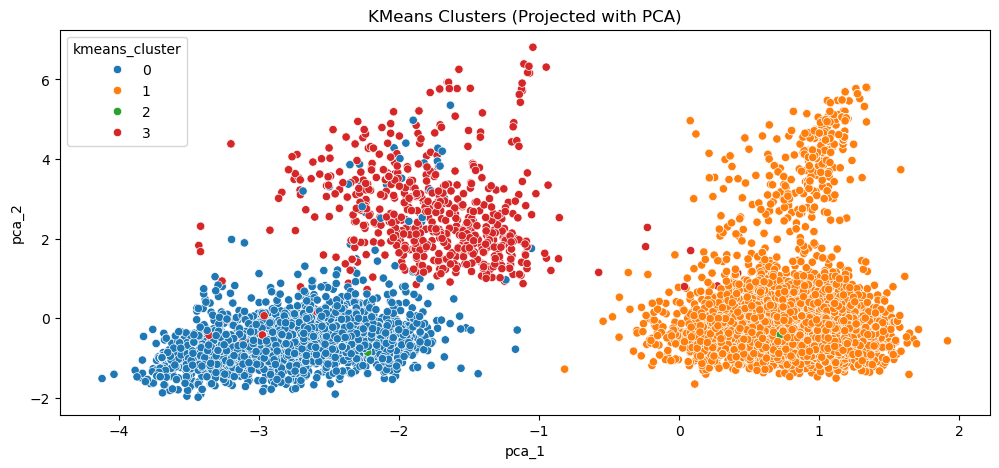

In [115]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], hue=df_encoded["kmeans_cluster"], palette="tab10")
plt.title("KMeans Clusters (Projected with PCA)")
plt.show()

In [ ]:
def get_kdist(k, data):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, _ = nbrs.kneighbors(data)
    sorted_kth_distances = np.sort(distances[:, k])[::-1]
    
    return list(sorted_kth_distances)

In [101]:
dbscan = DBSCAN(eps=10, min_samples=5, metric='euclidean')  # Adjust eps & min_samples based on dataset
df_encoded["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

print("DBSCAN Cluster Counts:")
print(df_encoded["dbscan_cluster"].value_counts())

DBSCAN Cluster Counts:
dbscan_cluster
-1      8218
 4      1440
 10      124
 8        66
 6        62
        ... 
 180       5
 69        5
 11        5
 168       5
 181       5
Name: count, Length: 185, dtype: int64


In [102]:
# Agglomerative (Hierarchical) Clustering
hierarchical = AgglomerativeClustering(n_clusters=6, linkage="ward")  # Adjust n_clusters
df_encoded["hierarchical_cluster"] = hierarchical.fit_predict(X_scaled)

# Count clusters
print("Hierarchical Cluster Counts:")
print(df_encoded["hierarchical_cluster"].value_counts())\

Hierarchical Cluster Counts:
hierarchical_cluster
2    8115
4    2412
0     784
3     604
5      26
1       8
Name: count, dtype: int64


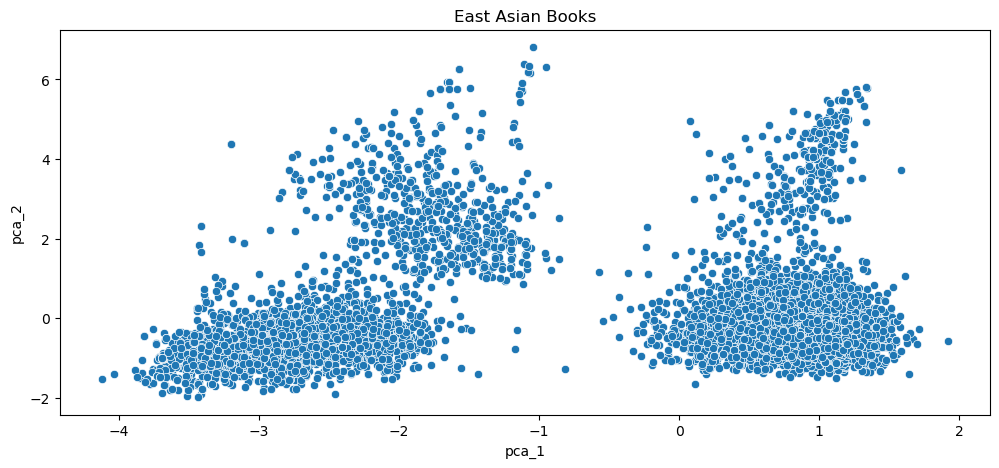

In [105]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], palette="viridis")
plt.title("East Asian Books")
plt.show()

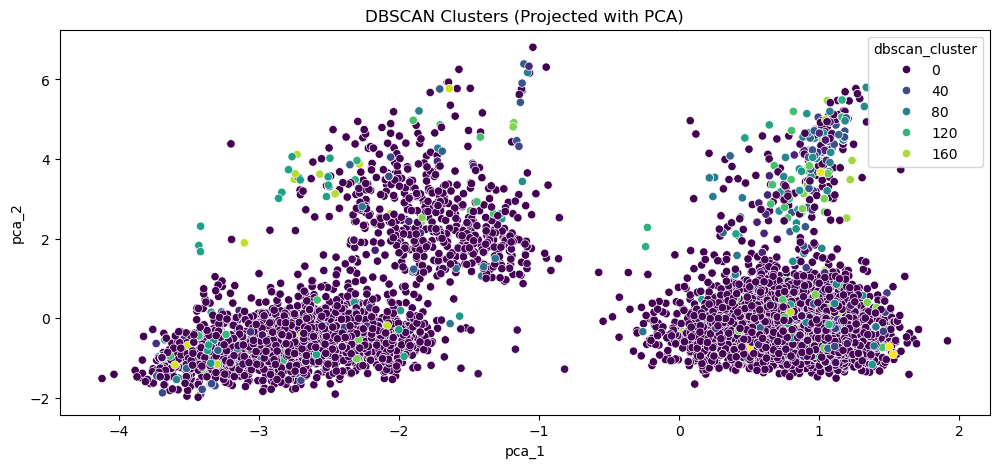

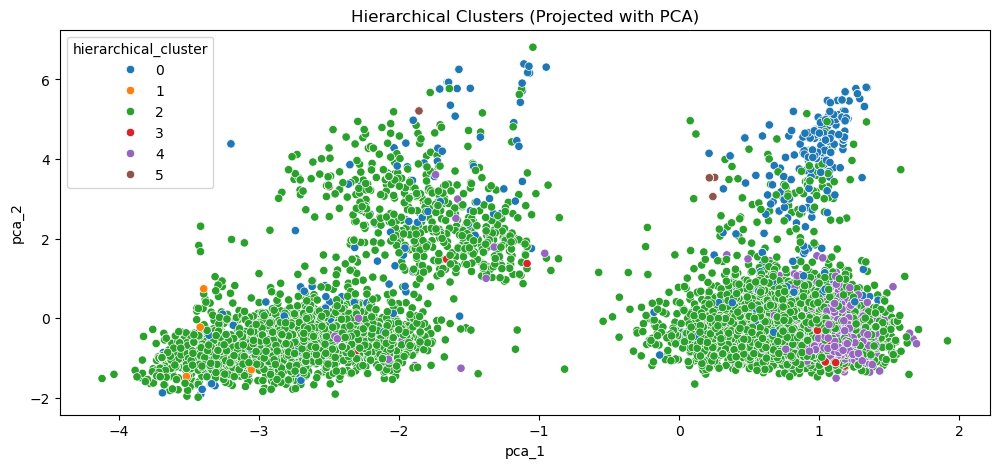

In [103]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_encoded["pca_1"] = pca_result[:, 0]
df_encoded["pca_2"] = pca_result[:, 1]

# DBSCAN Scatterplot
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], hue=df_encoded["dbscan_cluster"], palette="viridis")
plt.title("DBSCAN Clusters (Projected with PCA)")
plt.show()

# Hierarchical Clustering Scatterplot
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], hue=df_encoded["hierarchical_cluster"], palette="tab10")
plt.title("Hierarchical Clusters (Projected with PCA)")
plt.show()